# Import Tools

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import random
import os
import datetime

%load_ext tensorboard


--2023-03-23 22:17:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-23 22:17:45 (50.0 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import random
import os
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Confirm dataset in Tensorflow Datasets

In [1]:
datasets_list = tfds.list_builders() #get a list of all available datasets in TFDS
"food101" in datasets_list #check if target dataset in the list

NameError: ignored

# Import Dataset

In [ ]:
(train_data, test_data), ds_info = tfds.load(

    name = "food101",
    split=["train", "validation"],
    shuffle_files=True,
    as_supervised= True, #includes labels and the data (data, tuple)
    with_info=True )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteWETRPO/food101-train.tfrecord*...:   0%|          …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteWETRPO/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


# Data Exploration

View Features

In [ ]:
ds_info.features


FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

Create Class names

In [ ]:
class_names = ds_info.features["label"].names

In [ ]:
train_data_samples = train_data.take(6) 

for image, label in train_data_samples:
    print(
    f"""
        Image shape: {image.shape}
        Image datatype: {image.dtype}
        Target class from Food101: (tensor form): {label}
        Class name (str form): {class_names[label.numpy()]}
    """
    )


        Image shape: (512, 512, 3)
        Image datatype: <dtype: 'uint8'>
        Target class from Food101: (tensor form): 1
        Class name (str form): baby_back_ribs
    

        Image shape: (512, 512, 3)
        Image datatype: <dtype: 'uint8'>
        Target class from Food101: (tensor form): 7
        Class name (str form): bibimbap
    

        Image shape: (512, 512, 3)
        Image datatype: <dtype: 'uint8'>
        Target class from Food101: (tensor form): 6
        Class name (str form): beignets
    

        Image shape: (512, 512, 3)
        Image datatype: <dtype: 'uint8'>
        Target class from Food101: (tensor form): 96
        Class name (str form): tacos
    

        Image shape: (512, 512, 3)
        Image datatype: <dtype: 'uint8'>
        Target class from Food101: (tensor form): 38
        Class name (str form): fish_and_chips
    

        Image shape: (512, 512, 3)
        Image datatype: <dtype: 'uint8'>
        Target class from Food101: (tensor

In [ ]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Observations:
   - tensor values are not scaled
   - class names are label encoded
   - dtype can be changed from uint8 to int64
   - image shapes are inconsistent

### View images and labels

In [ ]:
def view_images(train = True, validation = False, test = False):
   
    '''
    Displays 12 images from specified dataset with their true labels as titles
    
    '''

    if test:
        data_samples = test_data.take(12) 
    
    else:
        data_samples = train_data.take(12)            
                
                
    plt.figure(figsize=(15,13))

    for i, data in enumerate(data_samples):
        image, label = data
        plt.subplot(4, 4, i+1)
        plt.imshow(image)
        plt.title(class_names[label].upper())
        plt.xticks([])
        plt.yticks([])


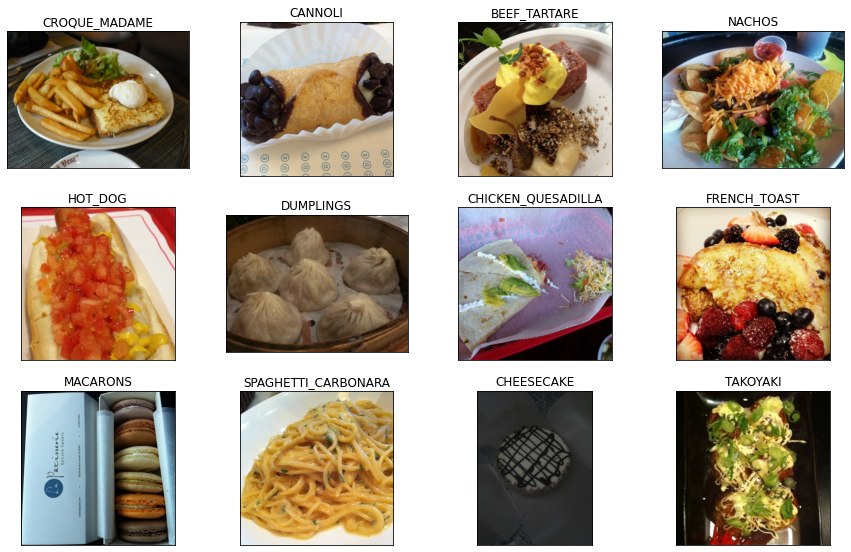

In [ ]:
view_images(test=True)

# Preprocess Data 

- changes to be made to the data

 - tensor values to be scaled
 - dtype is uint8 
      - can be changed to float32 or for mixed precision(float16 and float32)
 - image shapes are inconsistent
      - can be changed to (224)
 - store data in batches of size 32
 
 
#### Key note: 
If we use data on an EfficientNetBX pretrained model, no need to rescale (rescaling is built in)

In [ ]:
def preprocess_data(image, label, img_shape = 224, scale = False):
    
    '''
    Converts image datatype to "float32", reshapes image to [img_shape, img_shape] 
    '''   
    
    #reshape image
    image = tf.image.resize(image, [img_shape, img_shape])
    
    #change image dtype
    image = tf.cast(image, tf.float32)
    
    
    return image, label
    
    

# Data Augmentation

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) (nor required for EfficientNet)
],
  name = "data_augmentaion"
)


### Normal Image

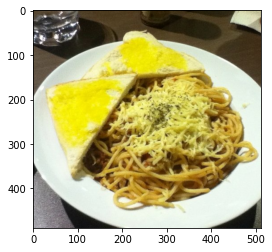

In [ ]:
for items in train_data.take(1):
  image, label = items
plt.imshow(image);


### Augmented Image

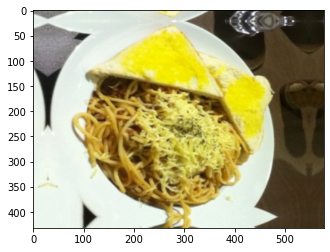

In [ ]:
image_aug = data_augmentation(image, training = True)
plt.imshow(image_aug/255.)

# Batch and prepare Datasets
    
- Following Tensorflow's best practices summary (to speed up data loading time)
    https://www.tensorflow.org/guide/data_performance


## Prepare Train Dataset


- Map train_data to preprocessing function
    - utilize all compute power from GPU (num_parallel_calls = tf.data.AUTOTUNE)
    
- Shuffle train data
    - how many at at time? (set buffer size to 1000)

- Turn into batches (batch_size = 32)
- Prefetch for faster loading (getting next batch ready while finding patterns on current batch)
     - buffer_size = tf.data.AUTOTUNE
    

In [ ]:
train_data = train_data.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


## Prepare Test Dataset

- Map test_data to preprocessing function
    - utilize all compute power from GPU (num_parallel_calls = tf.data.AUTOTUNE)
    
- Turn into batches (batch_size = 32)

- Prefetch for faster loading (getting next batch ready while finding patterns on current batch)
    - buffer_size = tf.data.AUTOTUNE

In [ ]:
test_data = test_data.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

test_data = test_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


# Create Modelling Callbacks

- Tensorboard callback 
    - to log training results
- ModelCheckpoint callback 
    - to save model's progress after feature extraction
    - save model's best performace on epoch with highest val accuracy
- Early stopping
    - to stop model training early is a certain metric stops improving
    - stop when val_accuracy hasnt improved within 3 epochs

In [2]:
#import tensorboard_callback from helper functions
from helper_functions import create_tensorboard_callback
 

#create model checkpoint
model_checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_path,
                                                     monitor = "val_acc",
                                                     save_weights_only=True,
                                                     verbose = 1)


model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                 patience=3)




ModuleNotFoundError: ignored

# Mixed Precision Training

- This is used to utilize the combination of float16 and float 32 dtypes to speed up model's performance.
- The layers the can or should use mixed precision will do that for a speed up 

In [ ]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy(policy="mixed_float16") 
#sets global data policy to mixed precision

mixed_precision.global_policy() # should output "mixed_float16"

<Policy "mixed_float16">

In [ ]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

NameError: ignored

Observations:

  - layer.name - human readable name
    
  - layer.trainable - is the layer trainable
    
  - layer.dtype - the data type a layer stores ite variables in
    
  - layer.dtype_policy - the data type policy a layer computes on its variables with
    
    
Key note: layers which can take benefit of float16, thus store more tensors in the GPU memory will do so. 

# Running Model Experiments
1. model_1 - Feature Extraction Transfer learning (EfficientNetB0) with Data Augmentation
2. model_1 - Finetuning 
3. model_2 - Feature Extraction Transfer learning (EfficientNetB0) without Data Augmentation
4. model_2 - Finetuning 

# Create Model_1

In [ ]:


from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
#set to false because we are customizing model (adding more layers) 
 
base_model.trainable = False
#when training our model with train data, we want the feature extraction model 
#to keep that preexisting patters not get trained more


#Create Functional model 

inputs = tf.keras.layers.Input(shape=input_shape, name = "input_layer")
print(inputs.shape)

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs, training = True) 
print(x.shape)

#note: efficientnet has sclaing built in, if that was not the case
#x = preprocessing.Rescaling(1./255)(inputs)

x = base_model(x, training = False) #setting model as inference again
print(x.shape)


x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(x.shape)


x = layers.Dense(len(class_names))(x) 
# one neuron per class 

# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 

model_1 = tf.keras.Model(inputs, outputs)


16705208/16705208 [==============================] - 1s 0us/step


(None, 224, 224, 3)


(None, None, None, 3)
(None, None, None, 1280)
(None, 1280)


## Compile Model_1

In [ ]:
model_1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer = tf.keras.optimizers.Adam(),
             metrics="accuracy")


## Model_1 Summary

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentaion (Sequentia  (None, None, 3)          0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0     

## Fit Model_1

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')


initial_epochs = 5
model_1_history = model_1.fit(train_data, 
                                                     epochs=initial_epochs,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.25 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "Model_1_efficientnetb0_feature_extract"),
                                                                model_checkpoint,
                                                               model_early_stopping])




Saving TensorBoard log files to: training_logs/Model_1_efficientnetb0_feature_extract/20230323-200148
Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 2.0807 - accuracy: 0.4996
Epoch 1: saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 655s 275ms/step - loss: 2.0807 - accuracy: 0.4996 - val_loss: 1.4639 - val_accuracy: 0.6198
Epoch 2/5
2368/2368 [==============================] - ETA: 0s - loss: 1.5990 - accuracy: 0.5922
Epoch 2: saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 585s 246ms/step - loss: 1.5990 - accuracy: 0.5922 - val_loss: 1.3531 - val_accuracy: 0.6475
Epoch 3/5
2368/2368 [==============================] - ETA: 0s - loss: 1.4720 - accuracy: 0.6213
Epoch 3: saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 639s 269ms/step - loss: 1.4720 - accuracy: 0.6213 - val_loss: 1.3127 - val_accuracy: 0.6521
Epoch 4/5
2368/2368 [======================

Model 1 Evaluation on Test data

In [ ]:
#model_1_results = model_1.evaluate(test_data)

model_1_results

[1.2999380826950073, 0.6524752378463745]

# Fine Tune Model_1

Key note: Fine tuning works best after training a feature extraction model for a few epochs with large amounts of custom data. Doing this will have the weights in the output layer trained. 

- Then work backwards and have the last layers of the feature extraction model (base model) trained on your custom data through fine tuning

- Fine tined Model 
    - unfreeze base model's last few layers for them to be fine tuned on training data
    - the top layers of the base model is learning the general features from the image

In [ ]:
model_1.layers[2].trainable

False

#Fine Tune base model

### View the number of trainable variables in model

In [ ]:
print(len(model_1.trainable_variables))

2


### View the number of trainable layers in model

In [ ]:
for num, i in enumerate(model_1.layers):
    print(num, i, i.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7f7fcfed8760> True
1 <keras.engine.sequential.Sequential object at 0x7f7fe03ae190> True
2 <keras.engine.functional.Functional object at 0x7f7fcafdf8b0> False
3 <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f7fcafdffd0> True
4 <keras.layers.core.dense.Dense object at 0x7f7fd8fc2190> True
5 <keras.layers.core.activation.Activation object at 0x7f7fd8529310> True


### View Model_1's Base Model( EfficientNetB0) layers

In [ ]:
for num, layer in enumerate(model_1.layers[2].layers):
        print (num, layer.name, layer.trainable)

### Modify Model_1's base model
- Set layers to untrainable, except last 10

In [ ]:
base_model.trainable = True

for num, layer in enumerate(model_1.layers[2].layers[:-10]):
    layer.trainable = False
    print(num, layer.name, layer.trainable)

## Recompile Model_1

- Model has to be recompiled whenever there is a change

Key Note: Because we are updating already learned weights/patterns, its a good rule of thumb to not have those weights/patterns be updated too much. We dont want to change the patterns it has learned in the first fitting too much due to the risk of overfitting.

The defailt lr in Adam is 0.001, Rule of thumb when fine tuning, to time it by 10X, therefore lr should be .0001

learning_rate = dictates how much a model should update its internal patterns/weights eopoch to epoch or sample to sample depending on the loss & optimizer  
determines how much the model should learn

In [ ]:
model_1.compile(loss =tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
             metrics="accuracy")


In [ ]:

for num, layer in enumerate(model_1.layers[2].layers):
    
    print(num, layer.name, layer.trainable)

### View the number of trainable variables in model




In [ ]:
print(len(model_1.trainable_variables))

12


# Fit Model_1 Finetuned

In [ ]:
fine_tune_epochs = initial_epochs + 5
model_1_history_fine_tuned = model_1.fit(train_data, 
                                                     epochs=fine_tune_epochs,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.25 * len(test_data)),
                                                      initial_epoch= model_1_history.epoch[-1], #access the last epoch from model_1_history and starts from thre
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "Model_1_efficientnetb0_feature_extract_fine_tune"),
                                                                model_checkpoint,
                                                               model_early_stopping])

Saving TensorBoard log files to: training_logs/Model_1_efficientnetb0_feature_extract_fine_tune/20230323-210731
Epoch 5/10
2368/2368 [==============================] - ETA: 0s - loss: 1.5107 - accuracy: 0.6087
Epoch 5: saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 588s 242ms/step - loss: 1.5107 - accuracy: 0.6087 - val_loss: 1.2413 - val_accuracy: 0.6637
Epoch 6/10
2368/2368 [==============================] - ETA: 0s - loss: 1.2715 - accuracy: 0.6624
Epoch 6: saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 574s 241ms/step - loss: 1.2715 - accuracy: 0.6624 - val_loss: 1.2063 - val_accuracy: 0.6723
Epoch 7/10
2368/2368 [==============================] - ETA: 0s - loss: 1.1399 - accuracy: 0.6916
Epoch 7: saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 574s 242ms/step - loss: 1.1399 - accuracy: 0.6916 - val_loss: 1.1373 - val_accuracy: 0.6962
Epoch 8/10
2368/2368 [========

In [ ]:
model_1_results_fine_tune = model_1.evaluate(test_data)

790/790 [==============================] - 171s 216ms/step - loss: 1.1853 - accuracy: 0.6903


# Visualize Model Performance

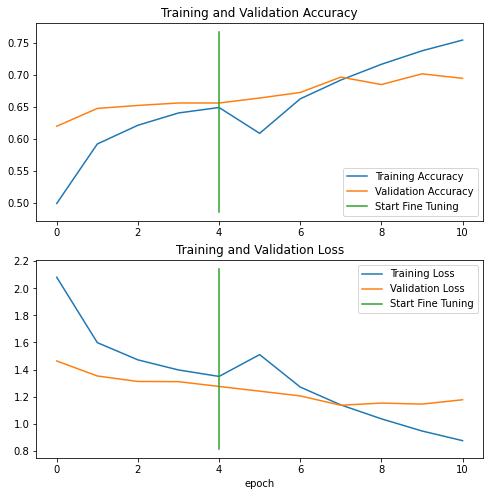

In [ ]:
compare_historys(model_1_history,model_1_history_fine_tuned)

# Observation:
  - Fine tuning has decreased Loss and improved accuracy

# Create Model_2 
- without data augmentation

# Model_2 Callbacks

In [ ]:
#import tensorboard_callback from helper functions
from helper_functions import create_tensorboard_callback
 

#create model checkpoint
model_2_checkpoint_path = "model_checkpoints/cp.ckpt"
model_2_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_2_checkpoint_path,
                                                     monitor = "val_acc",
                                                     save_weights_only=True,
                                                     verbose = 1)


model_2_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                 patience=3)




Create Model_2

In [ ]:


from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
#set to false because we are customizing model (adding more layers) 
 
base_model.trainable = False
#when training our model with train data, we want the feature extraction model 
#to keep that preexisting patters not get trained more


#Create Functional model 

inputs = tf.keras.layers.Input(shape=input_shape, name = "input_layer")
print(inputs.shape)


#note: efficientnet has sclaing built in, if that was not the case
#x = preprocessing.Rescaling(1./255)(inputs)

x = base_model(inputs, training = False) #setting model as inference again
print(x.shape)


x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(x.shape)


x = layers.Dense(len(class_names))(x) 
# one neuron per class 

# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 

model_2 = tf.keras.Model(inputs, outputs)


(None, 224, 224, 3)
(None, 7, 7, 1280)
(None, 1280)


# Compile Model_2

In [ ]:
model_2.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer = tf.keras.optimizers.Adam(),
             metrics="accuracy")


In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

# Fit Model_2

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')


initial_epochs = 5
model_2_history = model_2.fit(train_data, 
                                                     epochs=initial_epochs,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.25 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "Model_2_efficientnetb0_feature_extract"),
                                                                model_2_checkpoint,
                                                               model_2_early_stopping])




Saving TensorBoard log files to: training_logs/Model_2_efficientnetb0_feature_extract/20230323-224446
Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 1.7154 - accuracy: 0.5840
Epoch 1: saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 193s 77ms/step - loss: 1.7154 - accuracy: 0.5840 - val_loss: 1.1322 - val_accuracy: 0.6975
Epoch 2/5
2368/2368 [==============================] - ETA: 0s - loss: 1.1995 - accuracy: 0.6885
Epoch 2: saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 184s 77ms/step - loss: 1.1995 - accuracy: 0.6885 - val_loss: 1.0306 - val_accuracy: 0.7181
Epoch 3/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.0549 - accuracy: 0.7230
Epoch 3: saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 186s 78ms/step - loss: 1.0549 - accuracy: 0.7230 - val_loss: 0.9924 - val_accuracy: 0.7272
Epoch 4/5
2367/2368 [=========================

In [ ]:
model_2_results = model_2.evaluate(test_data)

790/790 [==============================] - 53s 66ms/step - loss: 0.9746 - accuracy: 0.7328


# Fine Tune Model_2

Key note: Fine tuning works best after training a feature extraction model for a few epochs with large amounts of custom data. Doing this will have the weights in the output layer trained. 

- Then work backwards and have the last layers of the feature extraction model (base model) trained on your custom data through fine tuning

- Fine tined Model 
    - unfreeze base model's last few layers for them to be fine tuned on training data
    - the top layers of the base model is learning the general features from the image

In [ ]:
model_2.layers[1].trainable

False

### View the number of trainable variables in model

In [ ]:
print(len(model_2.trainable_variables))

2


### View the number of trainable layers in model_2


In [ ]:
for num, i in enumerate(model_2.layers):
    print(num, i, i.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7f7fccd7c3a0> True
1 <keras.engine.functional.Functional object at 0x7f7fca7b9580> False
2 <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f7fc8f1a670> True
3 <keras.layers.core.dense.Dense object at 0x7f7f2274a940> True
4 <keras.layers.core.activation.Activation object at 0x7f7f218a0be0> True


### View Model_2's Base Model( EfficientNetB0) layers

In [ ]:
for num, layer in enumerate(model_2.layers[1].layers):
        print (num, layer.name, layer.trainable)

### Modify Model_1's base model
- Set layers to untrainable, except last 10

In [ ]:
base_model.trainable = True

for num, layer in enumerate(model_2.layers[1].layers[:-10]):
    layer.trainable = False
    print(num, layer.name, layer.trainable)

## Recompile Model_2

- Model has to be recompiled whenever there is a change

Key Note: Because we are updating already learned weights/patterns, its a good rule of thumb to not have those weights/patterns be updated too much. We dont want to change the patterns it has learned in the first fitting too much due to the risk of overfitting.

The defailt lr in Adam is 0.001, Rule of thumb when fine tuning, to time it by 10X, therefore lr should be .0001

learning_rate = dictates how much a model should update its internal patterns/weights eopoch to epoch or sample to sample depending on the loss & optimizer  
determines how much the model should learn

In [ ]:
model_2.compile(loss =tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
             metrics="accuracy")


### View Model_2's Base Model( EfficientNetB0) layers


In [ ]:
for num, layer in enumerate(model_2.layers[1].layers):
        print (num, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

### View the number of trainable variables in model


In [ ]:
print(len(model_2.trainable_variables))

12


# Fit Model_2 Finetuned

In [ ]:
fine_tune_epochs = initial_epochs + 5
model_2_history_fine_tuned = model_2.fit(train_data, 
                                                     epochs=fine_tune_epochs,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.25 * len(test_data)),
                                                      initial_epoch= model_2_history.epoch[-1], #access the last epoch from model_1_history and starts from thre
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "Model_2_efficientnetb0_feature_extract_fine_tune"),
                                                                model_2_checkpoint,
                                                               model_2_early_stopping])

Saving TensorBoard log files to: training_logs/Model_2_efficientnetb0_feature_extract_fine_tune/20230323-230918
Epoch 5/10
2368/2368 [==============================] - ETA: 0s - loss: 0.7575 - accuracy: 0.7983
Epoch 5: saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 215s 83ms/step - loss: 0.7575 - accuracy: 0.7983 - val_loss: 0.9371 - val_accuracy: 0.7430
Epoch 6/10
2368/2368 [==============================] - ETA: 0s - loss: 0.6216 - accuracy: 0.8353
Epoch 6: saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 187s 78ms/step - loss: 0.6216 - accuracy: 0.8353 - val_loss: 0.9305 - val_accuracy: 0.7444
Epoch 7/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.5209 - accuracy: 0.8614
Epoch 7: saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 199s 83ms/step - loss: 0.5210 - accuracy: 0.8614 - val_loss: 0.9348 - val_accuracy: 0.7527
Epoch 8/10
2368/2368 [===========

In [ ]:
#model_2_results_fine_tuned = model_2.evaluate(test_data)



False

In [ ]:
from helper_functions import compare_historys

# Visualize both Model's Performance

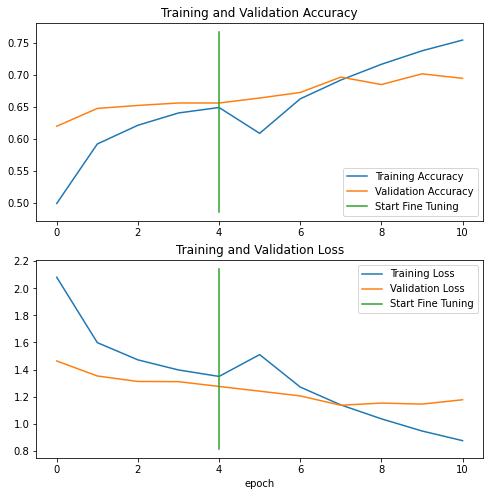

In [ ]:
compare_historys(model_1_history, model_1_history_fine_tuned)

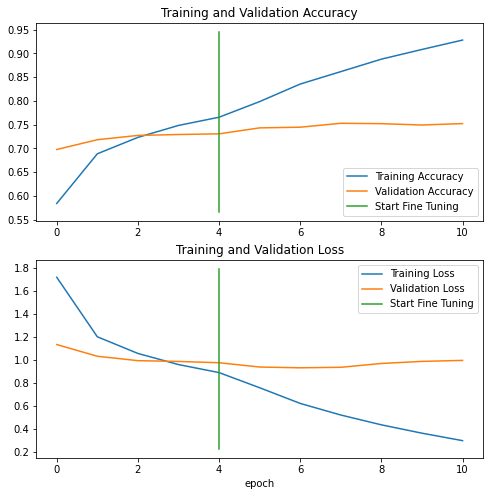

In [ ]:
compare_historys(model_2_history, model_2_history_fine_tuned)

Observation:
  - Fine tuning has decreased Loss and improved Accuracy for both models
  - Model_2 has performed better than Model_1 without data augmention